## Import libraries

In [1]:
import gc
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import PReLU, Input, Dropout, Add
from tensorflow.keras.layers import Flatten, Embedding, Conv1D
from tensorflow.keras.layers import Concatenate, Dense, Reshape

## Prepare data for model training

In [2]:
with open("../input/he-pgd-turkey-ham/MathCoThon_Ready_Sandwich.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']

del processed_data
gc.collect()

42

In [3]:
cat_cols = [
    "Genes in mother's side",
    'Inherited from father',
    'Maternal gene',
    'Paternal gene',
    'Status',
    'Respiratory Rate (breaths/min)',
    'Heart Rate (rates/min',
    'Follow-up',
    'Gender',
    'Birth asphyxia',
    'Autopsy shows birth defect (if applicable)',
    'Place of birth',
    'Folic acid details (peri-conceptional)',
    'H/O serious maternal illness',
    'H/O radiation exposure (x-ray)',
    'H/O substance abuse',
    'Assisted conception IVF/ART',
    'History of anomalies in previous pregnancies',
    'Birth defects',
    'Blood test result',
    'Parental consent',
    'Test 1','Test 2','Test 3','Test 4','Test 5',
    'Institute Name',
    'Institute Addr',
    'Institute State',
    'Institute Zipcode',
    "No. of previous abortion",
    'Symptom 1','Symptom 2','Symptom 3','Symptom 4','Symptom 5'
]

train_df[cat_cols] = train_df[cat_cols].astype(int)
test_df[cat_cols] = test_df[cat_cols].astype(int)

num_cols = [col for col in test_df.columns if col not in cat_cols]
len(cat_cols), len(num_cols)

(36, 955)

In [4]:
temp_df = train_df.groupby(['target']).size().reset_index().rename(columns={0:'count'})
total_count = np.sum(temp_df['count'].values)
temp_df['class%'] = (temp_df['count'] / total_count) * 100
lowest_pct = min(temp_df['class%'])
temp_df['class_weight'] = lowest_pct / temp_df['class%']
class_weight = temp_df[['target', 'class_weight']].to_dict()['class_weight']
class_weight

{0: 0.15502555366269166,
 1: 0.019431988041853514,
 2: 0.022916142029715435,
 3: 0.6842105263157895,
 4: 1.0,
 5: 0.05505142165759225,
 6: 0.02893481717011128,
 7: 0.07410423452768729,
 8: 0.03560250391236306}

In [5]:
Xtrain = train_df.loc[:, ~train_df.columns.isin(['target'])].copy()
Ytrain = train_df['target'].copy()
Ytrain_oh = pd.get_dummies(train_df['target']).copy()
Xtest = test_df.copy()

print(f"Xtrain: {Xtrain.shape} \nYtrain: {Ytrain.shape} \nYtrain_oh: {Ytrain_oh.shape} \nXtest: {Xtest.shape}")

del train_df
del test_df
gc.collect()

Xtrain: (18047, 991) 
Ytrain: (18047,) 
Ytrain_oh: (18047, 9) 
Xtest: (9465, 991)


20

## Build the model

In [6]:
def dnn_model(cat_features, num_features):
    
    x_input1 = Input(shape=(cat_features,), name='Categorical_Features')
    x_input2 = Input(shape=(num_features,), name='Numeric_Features')
    
    x1 = Embedding(input_dim=32, output_dim=8,
                   embeddings_regularizer=l2(0.0003),
                   embeddings_initializer='lecun_normal')(x_input1)
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    
    x2 = Conv1D(filters=12, kernel_size=1, 
                strides=1, padding='same', 
                kernel_regularizer=l2(0.0003),
                kernel_initializer='lecun_normal')(x1)
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    x1 = PReLU()(x1)
    
    x2 = Dense(units=224, kernel_initializer='lecun_normal', 
               kernel_regularizer=l2(0.0005))(x_input2)
    x2 = BatchNormalization()(x2)
    x2 = PReLU()(x2)
    
    x1 = Flatten()(x1)
    xi = Concatenate()([x1, x2])
    xi = BatchNormalization()(xi)
    xi = Dropout(rate=0.35)(xi)
    
    x = Reshape((16, 32))(xi)
    
    x = Conv1D(filters=32, kernel_size=3, 
               strides=2, padding='same', 
               kernel_regularizer=l2(0.0009),
               kernel_initializer='he_uniform')(x)
    x = LayerNormalization(epsilon=1e-5)(x)
    x = PReLU()(x)
    
    x1 = Conv1D(filters=64, kernel_size=3, 
                strides=1, padding='same', 
                kernel_regularizer=l2(0.0009),
                kernel_initializer='he_uniform')(x)
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    x1 = PReLU()(x1)
    
    x2 = Conv1D(filters=64, kernel_size=3, 
                strides=1, padding='same', 
                kernel_regularizer=l2(0.0009),
                kernel_initializer='he_uniform')(x1)
    x2 = LayerNormalization(epsilon=1e-5)(x2)
    x2 = PReLU()(x2)
    
    x2 = Conv1D(filters=64, kernel_size=3, 
                strides=1, padding='same', 
                kernel_regularizer=l2(0.0009),
                kernel_initializer='he_uniform')(x2)
    x2 = LayerNormalization(epsilon=1e-5)(x2)
    x2 = PReLU()(x2)
    
    x = Add()([x1, x2])
    x = BatchNormalization()(x)
    
    x = Conv1D(filters=128, kernel_size=3, 
               strides=2, padding='same', 
               kernel_regularizer=l2(0.0009),
               kernel_initializer='he_uniform')(x)
    x = LayerNormalization(epsilon=1e-5)(x)
    x = PReLU()(x)
    
    x = Flatten()(x)
    x = Add()([x, xi])
    x = BatchNormalization()(x)
    
    x = Dense(units=32, kernel_initializer='lecun_normal', 
              kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = PReLU()(x)
    x = Dropout(rate=0.25)(x)

    x_output = Dense(units=9, activation='softmax', 
                     kernel_initializer='lecun_normal')(x)

    model = Model(inputs=[x_input1, x_input2], 
                  outputs=x_output, name='DNN_Model')
    return model

In [7]:
model = dnn_model(len(cat_cols), len(num_cols))
model.summary()

Model: "DNN_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Categorical_Features (InputLaye [(None, 36)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 8)        256         Categorical_Features[0][0]       
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 36, 8)        16          embedding[0][0]                  
__________________________________________________________________________________________________
Numeric_Features (InputLayer)   [(None, 955)]        0                                            
__________________________________________________________________________________________

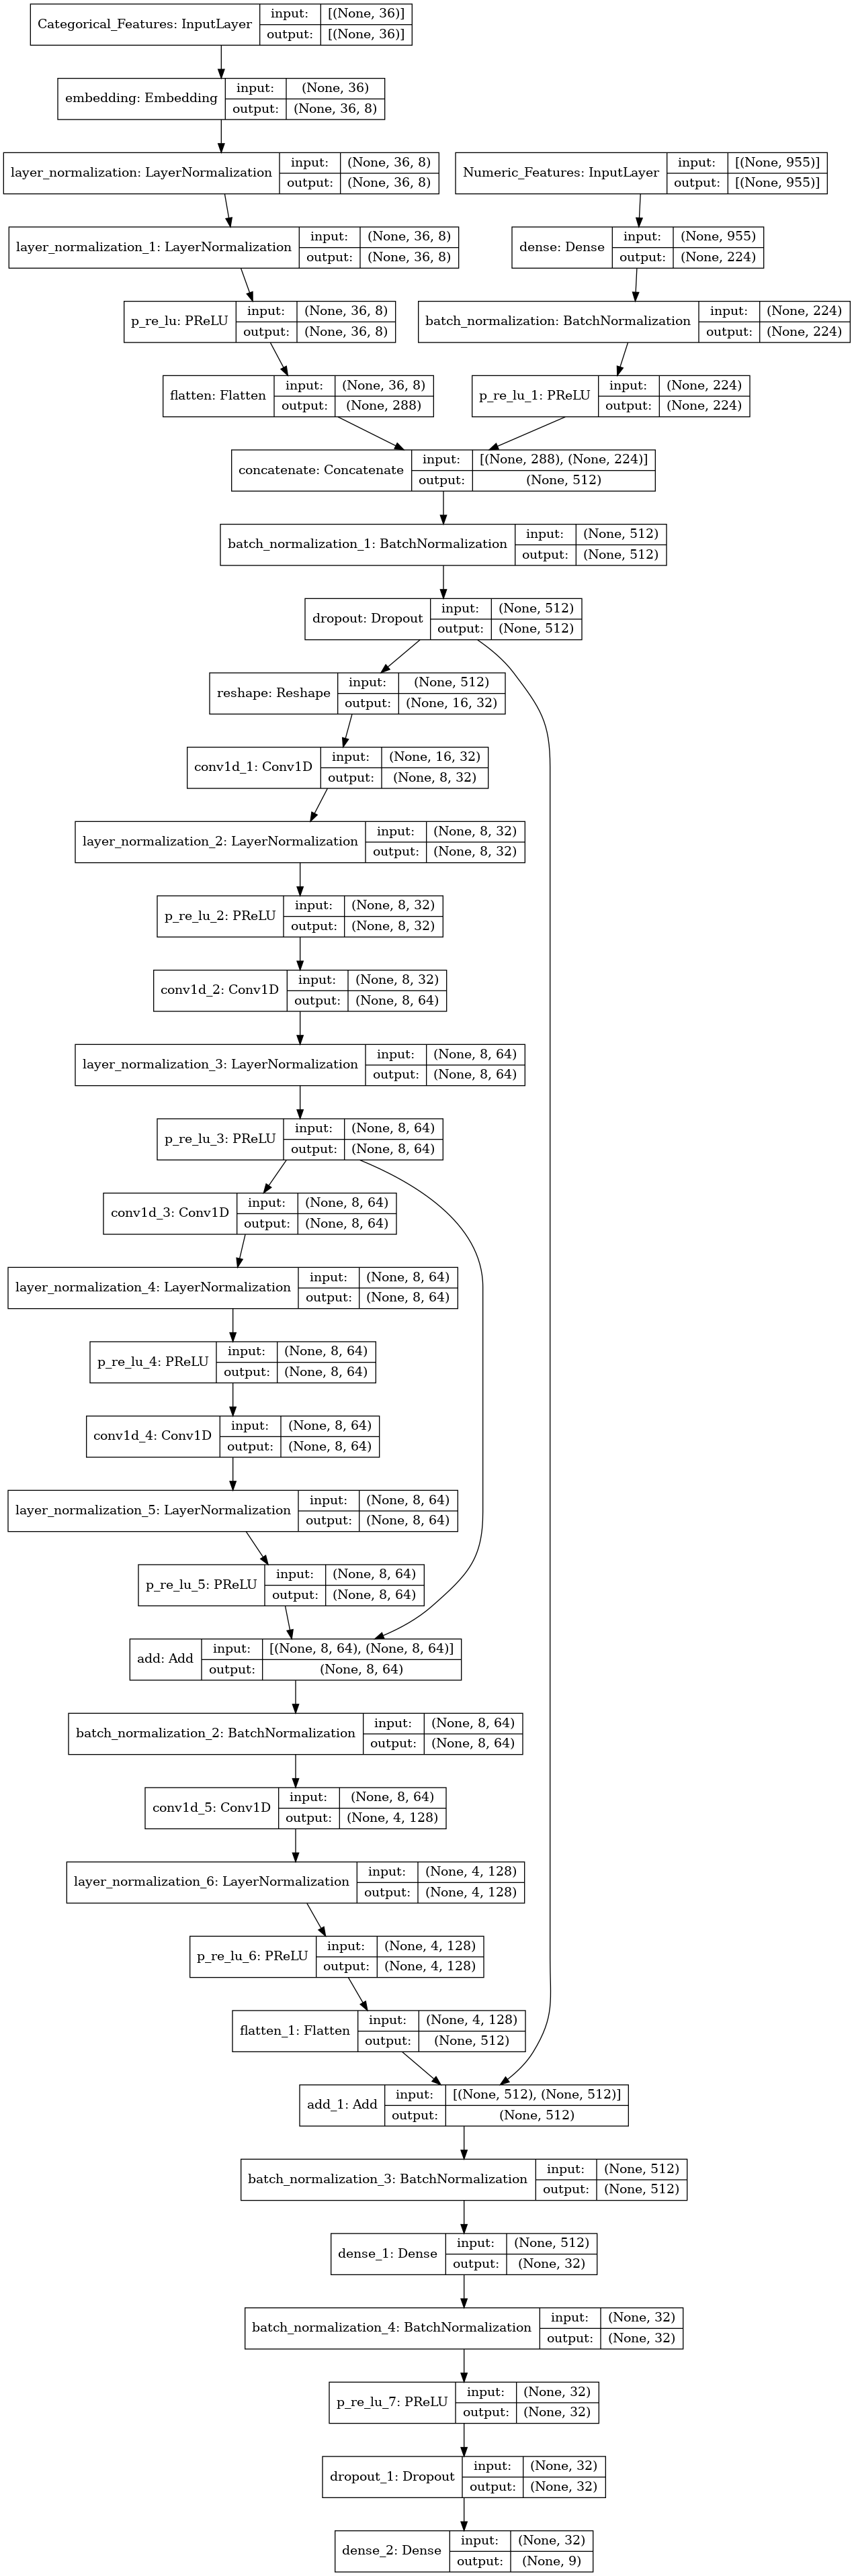

In [8]:
plot_model(
    model, to_file='./DNN_Model.png', 
    show_shapes=True, show_layer_names=True
)

## Train the model

In [9]:
FOLD = 10
VERBOSE = 0
BATCH_SIZE = 128
SEEDS = [2020, 2022]

counter = 0
oof_score = 0
y_pred_meta_dnn = np.zeros((Xtrain.shape[0], 9))
y_pred_final_dnn = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):
        counter += 1

        train_x, val_x = Xtrain.iloc[train], Xtrain.iloc[val]
        train_y, val_y = Ytrain.iloc[train], Ytrain.iloc[val]
        train_y_oh, val_y_oh = Ytrain_oh.iloc[train], Ytrain_oh.iloc[val]

        tf.random.set_seed(seed+idx)
        model = dnn_model(len(cat_cols), len(num_cols))
        
        model.compile(loss='categorical_crossentropy',
                      metrics=['categorical_accuracy'],
                      optimizer=Adamax(lr=1e-2))

        early = EarlyStopping(monitor="val_loss", mode="min", 
                              restore_best_weights=True, 
                              patience=10, verbose=VERBOSE)

        reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.25, 
                                      min_lr=1e-6, patience=4, 
                                      verbose=VERBOSE, mode='min')

        chk_point = ModelCheckpoint('./DNN_model.h5', 
                                    monitor='val_loss', verbose=VERBOSE, 
                                    save_best_only=True, mode='min')
        
        history = model.fit(
            [train_x[cat_cols], train_x[num_cols]], train_y_oh, 
            batch_size=BATCH_SIZE,
            epochs=200, 
            verbose=VERBOSE, 
            class_weight=class_weight,
            workers=5,
            callbacks=[reduce_lr, early, chk_point], 
            validation_data=([val_x[cat_cols], val_x[num_cols]], val_y_oh)
        )
        
        model = load_model('./DNN_model.h5')

        y_pred = model.predict([val_x[cat_cols], val_x[num_cols]])
        y_pred_meta_dnn[val] += y_pred
        y_pred_final_dnn += model.predict([Xtest[cat_cols], Xtest[num_cols]])
        
        y_pred = np.array([np.argmax(y_pred, axis=1)]).T
        score = 100 * f1_score(val_y, y_pred, average='macro')
        
        oof_score += score
        seed_score += score
        print(f"Seed-{seed} | Fold-{(idx+1)} | OOF Score: {score}")
    
    print(f"\nSeed: {seed} | Aggregate OOF Score: {(seed_score / FOLD)}\n\n")


y_pred_meta_dnn = y_pred_meta_dnn / float(len(SEEDS))
y_pred_final_dnn = y_pred_final_dnn / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

Seed-2020 | Fold-1 | OOF Score: 30.43842335821164
Seed-2020 | Fold-2 | OOF Score: 30.9770885024172
Seed-2020 | Fold-3 | OOF Score: 30.70936064605487
Seed-2020 | Fold-4 | OOF Score: 32.26003432570473
Seed-2020 | Fold-5 | OOF Score: 31.101532315042636
Seed-2020 | Fold-6 | OOF Score: 32.40011384291979
Seed-2020 | Fold-7 | OOF Score: 28.608155356970062
Seed-2020 | Fold-8 | OOF Score: 31.846137637819165
Seed-2020 | Fold-9 | OOF Score: 30.758351129189787
Seed-2020 | Fold-10 | OOF Score: 31.598413940403127

Seed: 2020 | Aggregate OOF Score: 31.069761105473304


Seed-2022 | Fold-1 | OOF Score: 32.5688409999016
Seed-2022 | Fold-2 | OOF Score: 31.107419279804706
Seed-2022 | Fold-3 | OOF Score: 32.61187944362076
Seed-2022 | Fold-4 | OOF Score: 30.062721584578206
Seed-2022 | Fold-5 | OOF Score: 32.258593401984285
Seed-2022 | Fold-6 | OOF Score: 33.3155746917624
Seed-2022 | Fold-7 | OOF Score: 30.714581010920366
Seed-2022 | Fold-8 | OOF Score: 31.213256935364917
Seed-2022 | Fold-9 | OOF Score: 27.7

In [10]:
np.savez_compressed('./DNN_Meta_Features.npz',
                    y_pred_meta_dnn=y_pred_meta_dnn, 
                    oof_score=oof_score,
                    y_pred_final_dnn=y_pred_final_dnn)

## Create submission file

In [11]:
test_df = pd.read_csv("../input/predict-generic-disorder/dataset/test.csv")
submit_df = pd.DataFrame()
submit_df['Patient Id'] = test_df['Patient Id']
submit_df['target'] = np.array([np.argmax(y_pred_final_dnn, axis=1)]).T

submit_df['target'] = submit_df['target'].map({
    0: "Mitochondrial genetic inheritance disorders//Leber's hereditary optic neuropathy",
    1: 'Mitochondrial genetic inheritance disorders//Leigh syndrome',
    2: 'Mitochondrial genetic inheritance disorders//Mitochondrial myopathy',
    3: "Multifactorial genetic inheritance disorders//Alzheimer's",
    4: 'Multifactorial genetic inheritance disorders//Cancer',
    5: 'Multifactorial genetic inheritance disorders//Diabetes',
    6: 'Single-gene inheritance diseases//Cystic fibrosis',
    7: 'Single-gene inheritance diseases//Hemochromatosis',
    8: 'Single-gene inheritance diseases//Tay-Sachs'
})

submit_df.groupby(['target']).size().reset_index().rename(columns={0:'Count'})

,target,Count
0,Mitochondrial genetic inheritance disorders//L...,627
1,Mitochondrial genetic inheritance disorders//L...,3049
2,Mitochondrial genetic inheritance disorders//M...,1178
3,Multifactorial genetic inheritance disorders//...,353
4,Multifactorial genetic inheritance disorders//...,167
5,Multifactorial genetic inheritance disorders//...,626
6,Single-gene inheritance diseases//Cystic fibrosis,1932
7,Single-gene inheritance diseases//Hemochromatosis,583
8,Single-gene inheritance diseases//Tay-Sachs,950


In [12]:
submit_df['Genetic Disorder'] = submit_df['target'].apply(lambda x: x.split('//')[0])
submit_df['Disorder Subclass'] = submit_df['target'].apply(lambda x: x.split('//')[1])
submit_df.drop(['target'], axis=1, inplace=True)
submit_df.head()

,Patient Id,Genetic Disorder,Disorder Subclass
0,PID0x4175,Multifactorial genetic inheritance disorders,Diabetes
1,PID0x21f5,Single-gene inheritance diseases,Hemochromatosis
2,PID0x49b8,Multifactorial genetic inheritance disorders,Cancer
3,PID0x2d97,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x58da,Single-gene inheritance diseases,Cystic fibrosis


In [13]:
submit_df.to_csv("./DNN_submission.csv", index=False)

## Classification Report

In [14]:
def plot_confusion_matrix(cm, classes):

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Paired)
    plt.title('Confusion matrix', fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [15]:
y_pred = np.array([np.argmax(y_pred_meta_dnn, axis=1)]).T
print(classification_report(Ytrain, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.33      0.25       587
           1       0.46      0.49      0.47      4683
           2       0.39      0.27      0.32      3971
           3       0.12      0.56      0.20       133
           4       0.12      0.64      0.21        91
           5       0.34      0.24      0.28      1653
           6       0.45      0.46      0.45      3145
           7       0.31      0.40      0.35      1228
           8       0.34      0.31      0.32      2556

    accuracy                           0.38     18047
   macro avg       0.30      0.41      0.32     18047
weighted avg       0.39      0.38      0.38     18047



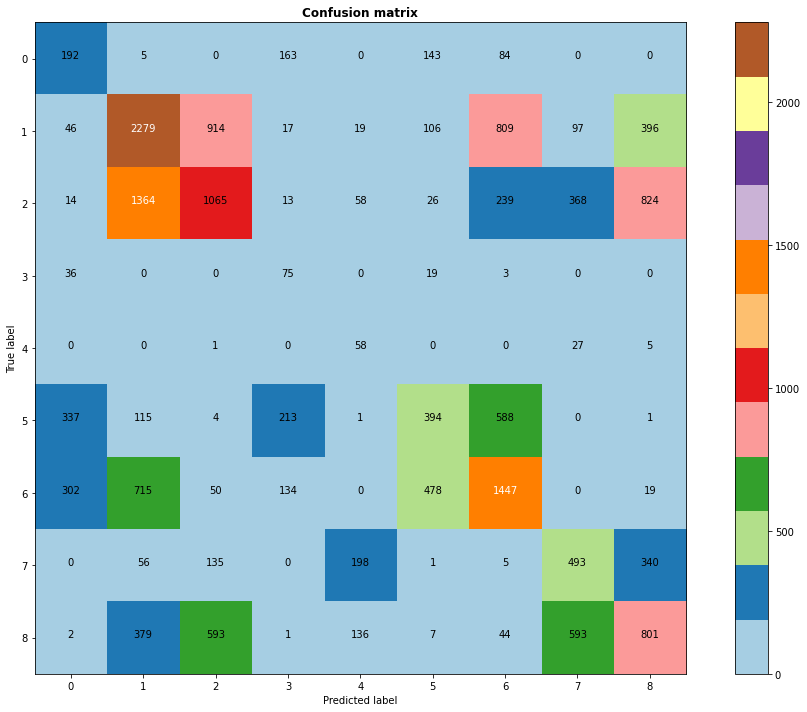

In [16]:
cnf_matrix = confusion_matrix(Ytrain, y_pred, labels=list(range(9)))
np.set_printoptions(precision=2)
plt.figure(figsize=(14,10))
plot_confusion_matrix(cnf_matrix, classes=list(range(9)))